In [1]:
# boiler plate
from collections import Counter
import pickle
from importlib import reload
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import ipdb
import mytf.utils as mu

tf.enable_eager_execution()

print(tf.executing_eagerly())


True


In [2]:
with open('models/2019-05-19T001217-UTC-outdata--SUBSET.pkl', 'rb') as fd:
    minidata = pickle.load(fd)

In [3]:
minidata.keys()

dict_keys(['x_train', 'x_test', 'y_train', 'y_test', 'y_train_original', 'y_test_original'])

In [11]:
# Trying this time to use a different input shape,
# this time batch_input_shape=(None, 256, 1)
# as opposed to input_shape=(None, 1)
#
# That's because each sequence has size of 256. 
# Still not sure if this is the correct way to do it.

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,   dropout=0.2, recurrent_dropout=0.2,
                batch_input_shape=(None, 256, 1), 
              ),
    # 4 because 'A', 'B', 'C', 'D'.
    tf.keras.layers.Dense(4)
])


# ValueError: Input 0 of layer lstm is incompatible with the layer: 
# expected ndim=3, found ndim=4. Full shape received: [None, None, 256, 1]

# when i tried this i got this error 
# stateful=True , with batch_input_shape=(None, 256, 1)
# ValueError: If a RNN is stateful, it needs to know its batch size. Specify the batch size of your input tensors: 
# - If using a Sequential model, specify the batch size by passing a `batch_input_shape` argument to your first layer.
# - If using the functional API, specify the batch size by passing a `batch_shape` argument to your Input layer.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
minidata['x_train'].shape

(47689, 256, 1)

In [9]:
# okay since this is minidataset... use all of it..
#Hand-tuned ... 
class_weights = {0: 0.1, 1: 0.5, 2: 0.1, 3: 0.3}

# everything basically..
training_indices = np.arange(0, minidata['x_train'].shape[0], 1)

%time dataset_batches = mu.build_dataset_weighty(  \
    minidata, training_indices, class_weights, \
        batch_size=1000)

Counter({3: 20000, 0: 10000, 2: 10000, 1: 7689})
weights_per_class,  tf.Tensor([9.99999975e-06 6.50279617e-05 9.99999975e-06 1.50000005e-05], shape=(4,), dtype=float32)
tf.Tensor(1.0005401, shape=(), dtype=float32)
CPU times: user 7.82 s, sys: 568 ms, total: 8.39 s
Wall time: 8.93 s


In [12]:
%time loss_history = mu.do_train(model, dataset_batches)

Instructions for updating:
Use tf.cast instead.
CPU times: user 5min 28s, sys: 2min 10s, total: 7min 38s
Wall time: 4min 55s


Text(0, 0.5, 'Loss [entropy]')

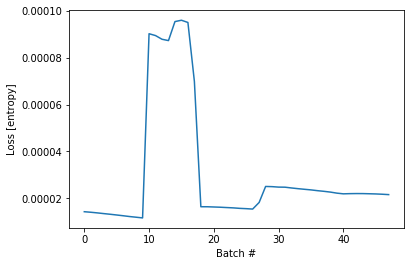

In [13]:
# ... 
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

In [14]:
# The loss curve still looks way too low . So again most likely there will be
# underfitting.

# predict from training set first..
# some random from here..

print(minidata['x_train'].shape)
train_subset = np.random.choice(np.arange(0, minidata['x_train'].shape[0], 1),
                               10000, replace=False)
print('subset, ', len(train_subset))
%time y_pred_train = model(tf.convert_to_tensor(minidata['x_train'][train_subset], dtype=tf.float32))


(47689, 256, 1)
subset,  10000
CPU times: user 27.9 s, sys: 8.66 s, total: 36.6 s
Wall time: 10.2 s


In [15]:
# First make sure this random training subset covers all four classes.
Counter(np.argmax(minidata['y_train'][train_subset, :], axis=1))
# 

Counter({3: 4217, 0: 2160, 1: 1546, 2: 2077})

In [16]:
# confusion... 
tf.confusion_matrix(
    np.argmax(minidata['y_train'][train_subset, :], axis=1),  # labels

    np.argmax(y_pred_train, axis=1), # predictions
    num_classes=4)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


<tf.Tensor: id=4438602, shape=(4, 4), dtype=int32, numpy=
array([[2160,    0,    0,    0],
       [ 785,  761,    0,    0],
       [2077,    0,    0,    0],
       [2526, 1691,    0,    0]], dtype=int32)>

In [ ]:
# Indeed, I have a feeling something is still terribly wrong. Anyway memory performance
# using just that small subset was at least way more tolerable.
#
# Prediction is taking seconds and not minutes.

In [17]:
#hmm try to specify the batch size... since i know it...

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,   dropout=0.2, recurrent_dropout=0.2,
                batch_input_shape=(1000, 256, 1), 
                         stateful=True
              ),
    # 4 because 'A', 'B', 'C', 'D'.
    tf.keras.layers.Dense(4)
])

In [18]:
# Ah darn first time I tried to train, i got this error...
#  
# InvalidArgumentError: Incompatible shapes: [689,64] vs. [1000,64] 
# [Op:Add] name: sequential_5/lstm_5/lstm_5/add/
#
# , because the last batch is not a 1000 batch size. 

# Got to clip the last 689 elements I guess.


%time loss_history = mu.do_train(model, dataset_batches)

InvalidArgumentError: Incompatible shapes: [689,64] vs. [1000,64] [Op:Add] name: sequential_5/lstm_5/lstm_5/add/

In [19]:
len(training_indices)

47689

In [20]:
class_weights = {0: 0.1, 1: 0.5, 2: 0.1, 3: 0.3}

# Try again but keep each batch 1000.
training_indices = np.arange(0, minidata['x_train'].shape[0], 1)[:47000]
print('training indices...', training_indices.shape)

%time dataset_batches = mu.build_dataset_weighty(  \
    minidata, training_indices, class_weights, \
        batch_size=1000)


training indices... (47000,)
Counter({3: 19311, 0: 10000, 2: 10000, 1: 7689})
weights_per_class,  tf.Tensor([9.9999997e-06 6.5027962e-05 9.9999997e-06 1.5535188e-05], shape=(4,), dtype=float32)
tf.Tensor(1.0005482, shape=(), dtype=float32)
CPU times: user 7.74 s, sys: 1.5 s, total: 9.25 s
Wall time: 12.1 s


In [21]:
# Okay try stateful train take #2... 
%time loss_history = mu.do_train(model, dataset_batches)


CPU times: user 5min 53s, sys: 3min 17s, total: 9min 10s
Wall time: 5min 51s


Text(0, 0.5, 'Loss [entropy]')

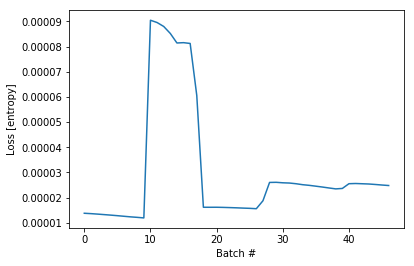

In [22]:
# ... 
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

In [25]:
# okay well the losses are still incredibly low. Actually 10x lower for some reason.

# Also looks like prediction also needs to be with 1000 size here as well...
# Since getting similar exception...
# InvalidArgumentError: Incompatible shapes: [10000,64] vs. [1000,64]
# [Op:Add] name: sequential_5/lstm_5/lstm_5/add/
train_subset_1 = train_subset[:1000]
%time y_pred_train = model(tf.convert_to_tensor(minidata['x_train'][train_subset_1], dtype=tf.float32))


CPU times: user 2.07 s, sys: 564 ms, total: 2.63 s
Wall time: 1.8 s


In [26]:
# confusion... 
tf.confusion_matrix(
    np.argmax(minidata['y_train'][train_subset_1, :], axis=1),  # labels

    np.argmax(y_pred_train[:1000], axis=1), # predictions
    num_classes=4)

<tf.Tensor: id=12727896, shape=(4, 4), dtype=int32, numpy=
array([[201,   0,   0,   0],
       [ 84,  83,   0,   0],
       [218,   0,   0,   0],
       [249, 165,   0,   0]], dtype=int32)>

In [ ]:
# Dang. So yea something still not right... need to keep looking.

In [30]:
# Now that I've got a different input shape, try w/o weights now.

# Each batch  1000.
training_indices = np.arange(0, minidata['x_train'].shape[0], 1)[:47000]
print('training indices...', training_indices.shape)

dataset_batches = mu.build_dataset(minidata, training_indices, batch_size=1000)


training indices... (47000,)


In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,   dropout=0.2, recurrent_dropout=0.2,
                batch_input_shape=(1000, 256, 1), 
                         stateful=True
              ),
    # 4 because 'A', 'B', 'C', 'D'.
    tf.keras.layers.Dense(4)
])

In [33]:
%time loss_history = mu.do_train_noweights(model, dataset_batches)


CPU times: user 5min 41s, sys: 2min 32s, total: 8min 13s
Wall time: 5min 15s


Text(0, 0.5, 'Loss [entropy]')

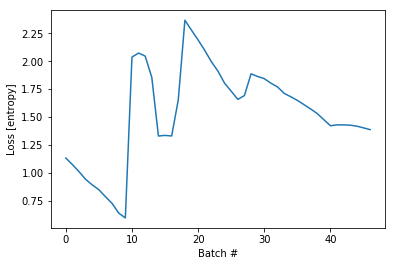

In [34]:
# ... 
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

In [ ]:
# umm okay so at least, after removing the crazy weights, we indeed know that
# the loss was so dang low because the weights were so extreme...


In [35]:
train_subset_1 = train_subset[:1000]
%time y_pred_train = model(tf.convert_to_tensor(minidata['x_train'][train_subset_1], dtype=tf.float32))


CPU times: user 2.11 s, sys: 681 ms, total: 2.79 s
Wall time: 2.25 s


In [36]:
# confusion... grr.. damn still quite crappy.
tf.confusion_matrix(
    np.argmax(minidata['y_train'][train_subset_1, :], axis=1),  # labels

    np.argmax(y_pred_train[:1000], axis=1), # predictions
    num_classes=4).numpy()

array([[201,   0,   0,   0],
       [ 84,  83,   0,   0],
       [218,   0,   0,   0],
       [249, 165,   0,   0]], dtype=int32)

In [39]:
# Going to compute confusion matrix across all the 1000-large train data
minidata['x_train'].shape

(47689, 256, 1)

In [42]:
%%time
confusion_vec = []

for i in range(47):
    this_slice = (1000*i, 1000*(i+1))
    y_pred_train = model(tf.convert_to_tensor(
            minidata['x_train'][this_slice[0]:this_slice[1]],
            dtype=tf.float32))
    assert y_pred_train.shape[0] == 1000
    
    confusion_vec.append(
        tf.confusion_matrix(
        np.argmax(minidata['y_train'][this_slice[0]:this_slice[1], :], axis=1),  # labels

        np.argmax(y_pred_train, axis=1), # predictions
        num_classes=4).numpy())
    


CPU times: user 1min 36s, sys: 12.6 s, total: 1min 49s
Wall time: 1min 15s


In [51]:
np.sum(confusion_vec, axis=0)

array([[10000,     0,     0,     0],
       [ 3837,  3852,     0,     0],
       [10000,     0,     0,     0],
       [12073,  7238,     0,     0]])

In [ ]:
# Okay indeed still quite asymmetric. I expected the asymmetry since now there are no
# weights, but this is on the other extreme indeed.

In [53]:
# Quick thought on whether i should scale the data perhaps..
minidata['x_train'][0,:2,:]

array([[-0.9586470767805308],
       [-0.9586470767805308]], dtype=object)

In [56]:
 
minidata['x_train'].shape # [0,:,:]

(47689, 256, 1)

In [59]:
llist = np.reshape(minidata['x_train'], newshape=(47689*256,))
print('min, ', min(llist), 'max, ', max(llist))

min,  -1.1162120493020151 max,  1.036747306158156


In [63]:
llist.shape

(12208384,)

In [60]:
from sklearn.preprocessing import MinMaxScaler


In [64]:
llist2 = np.reshape(minidata['x_train'], newshape=(47689*256,1))

In [66]:
llist2[:2]

array([[-0.9586470767805308],
       [-0.9586470767805308]], dtype=object)

In [67]:
# Going to see if this makes any difference...

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(llist2)
print('min, ', min(scaled_data), 'max, ', max(scaled_data))

/usr/local/miniconda3/envs/pandars3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


min,  [0.] max,  [1.]


In [68]:
# reshape it...
newminidata = {'x_train': np.reshape(scaled_data, newshape=(47689,256,1)),
              'y_train': minidata['y_train']}

In [78]:
newminidata['x_test'] = mu.scale_this_thing(minidata['x_test'], scaler)

In [ ]:
newminidata['y_test'] = minidata['y_test']

In [79]:
# okay... now try use that ..
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,   dropout=0.2, recurrent_dropout=0.2,
                batch_input_shape=(1000, 256, 1), 
                         stateful=True
              ),
    # 4 because 'A', 'B', 'C', 'D'.
    tf.keras.layers.Dense(4)
])

In [80]:
training_indices = np.arange(0, newminidata['x_train'].shape[0], 1)[:47000]
print('training indices...', training_indices.shape)

dataset_batches = mu.build_dataset(newminidata, training_indices, batch_size=1000)


training indices... (47000,)


In [81]:
%time loss_history = mu.do_train_noweights(model, dataset_batches)


CPU times: user 6min 5s, sys: 3min 38s, total: 9min 44s
Wall time: 6min 10s


Text(0, 0.5, 'Loss [entropy]')

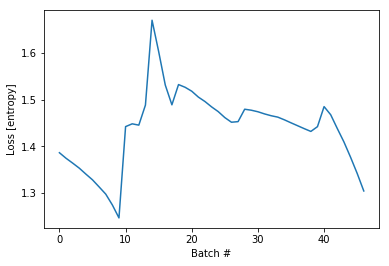

In [82]:
# ... 
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

In [ ]:
# hmm this does look a bit different.

In [83]:
%%time
confusion_vec = []

for i in range(47):
    this_slice = (1000*i, 1000*(i+1))
    y_pred_train = model(tf.convert_to_tensor(
            newminidata['x_train'][this_slice[0]:this_slice[1]],
            dtype=tf.float32))
    assert y_pred_train.shape[0] == 1000
    
    confusion_vec.append(
        tf.confusion_matrix(
        np.argmax(newminidata['y_train'][this_slice[0]:this_slice[1], :], axis=1),  # labels

        np.argmax(y_pred_train, axis=1), # predictions
        num_classes=4).numpy())
    


CPU times: user 1min 36s, sys: 11.9 s, total: 1min 48s
Wall time: 1min 14s


In [84]:
# full... confusion now ...
np.sum(confusion_vec, axis=0)

array([[    0,     0,     0, 10000],
       [    0,     0,     0,  7689],
       [    0,     0,     0, 10000],
       [    0,     0,     0, 19311]])

In [ ]:
# What the heck? Ummm.. So weird.